# Multi-Series Analysis Pipeline 🚀

**Ziel:** Automatisierte Analyse verschiedener Energie-Zeitreihen (Solar, Wind, Verbrauch, Preis) mit den besten Modellen.

Dieses Notebook:
1. Lädt nacheinander verschiedene Zeitreihen von SMARD
2. Führt Feature Engineering durch
3. Trainiert die Top-Modelle (XGBoost, LightGBM)
4. Vergleicht die Vorhersagbarkeit der verschiedenen Energieträger

In [1]:
# Imports
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Custom Loader
from data.smard_loader import load_smard_data

# Plotting Style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## 1. Konfiguration der Pipeline

In [2]:
# Zu analysierende Zeitreihen
DATA_SOURCES = [
    'solar',           # Photovoltaik
    'wind_onshore',    # Wind an Land
    'wind_offshore',   # Wind auf See
    'consumption',     # Stromverbrauch
    'price_day_ahead'  # Strompreis
]

# Zeitraum
START_DATE = '2022-01-01'
END_DATE = '2024-12-31'

# Train/Test Split
TEST_DAYS = 30  # Letzte 30 Tage zum Testen

## 2. Hilfsfunktionen

In [3]:
def create_features(df):
    """Erstellt Zeit-Features für ML-Modelle"""
    df = df.copy()
    
    # Zeit-Features
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['quarter'] = df['timestamp'].dt.quarter
    df['month'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year
    df['dayofyear'] = df['timestamp'].dt.dayofyear
    
    # Zyklische Features (wichtig für Uhrzeit/Monat)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    
    # Lag Features (Vergangenheit)
    # t-24 (gestern gleiche Zeit), t-168 (letzte Woche gleiche Zeit)
    df['lag_24'] = df['value'].shift(24)
    df['lag_48'] = df['value'].shift(48)
    df['lag_168'] = df['value'].shift(168)
    
    # Rolling Statistics
    df['rolling_mean_24'] = df['value'].shift(1).rolling(window=24).mean()
    df['rolling_std_24'] = df['value'].shift(1).rolling(window=24).std()
    
    # Drop NaNs created by lags
    df = df.dropna()
    
    return df

def evaluate_model(y_true, y_pred, model_name, dataset_name):
    """Berechnet Metriken"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Mean Absolute Percentage Error (MAPE)
    # Schutz vor Division durch Null
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    return {
        'Dataset': dataset_name,
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape
    }

## 3. Haupt-Pipeline

🚀 Starte Analyse für 5 Zeitreihen...


📊 Analysiere: SOLAR
Loading from cache: ..\data\raw\solar_2022-01-01_2024-12-31_hour.csv
Trainings-Daten: 25369 Stunden
Test-Daten: 720 Stunden (30 Tage)
  Training XGBoost...
  -> XGBoost R²: 0.8364
  Training LightGBM...
  -> LightGBM R²: 0.8329


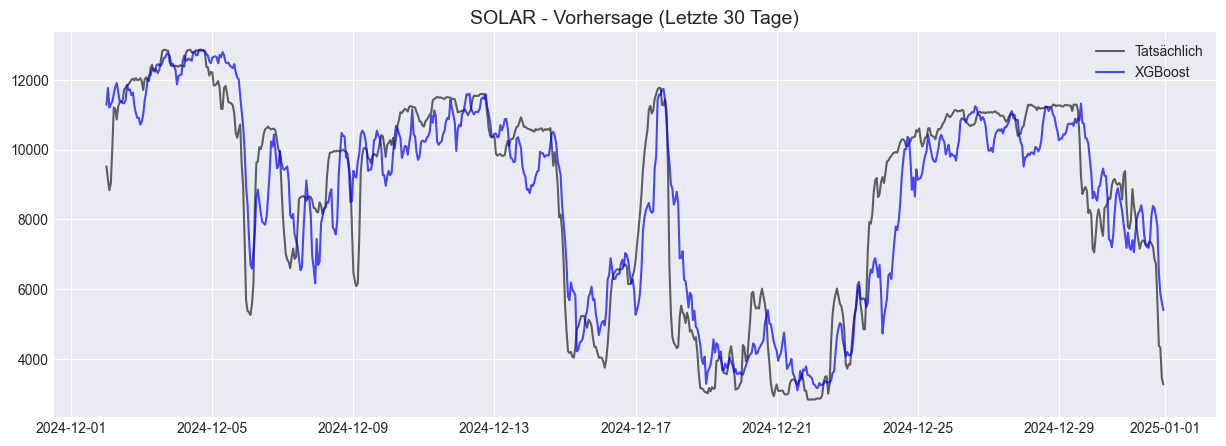


📊 Analysiere: WIND_ONSHORE
Period: 2022-01-01 to 2024-12-31
  Requesting: https://www.smard.de/app/chart_data/1225/DE/1225_DE_hour_1641164400000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/1225/DE/1225_DE_hour_1641769200000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/1225/DE/1225_DE_hour_1642374000000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/1225/DE/1225_DE_hour_1642978800000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/1225/DE/1225_DE_hour_1643583600000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/1225/DE/1225_DE_hour_1644188400000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/1225/DE/1225_DE_hour_1644793200000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/1225/DE/1225_DE_hour_1645398000000.json
    Downloaded 168 records
  R

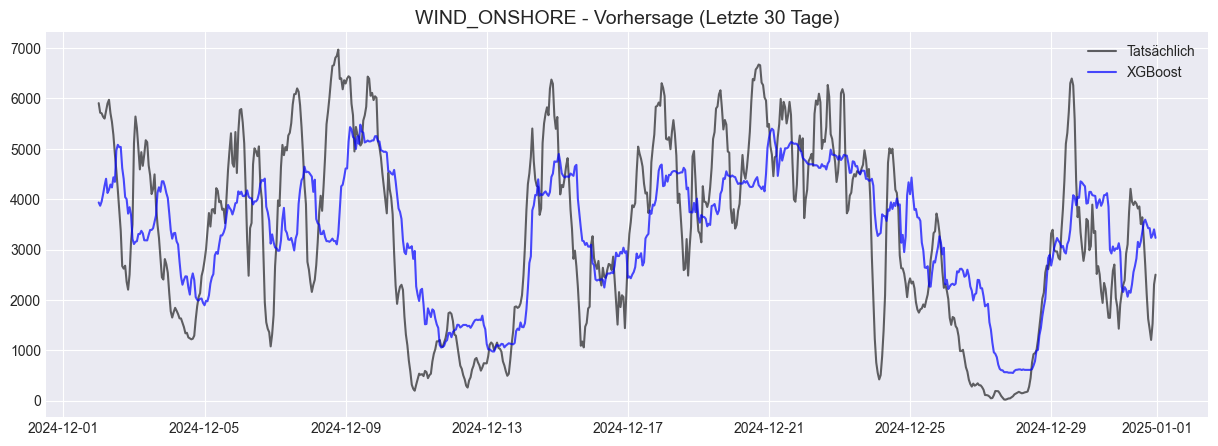


📊 Analysiere: WIND_OFFSHORE
Period: 2022-01-01 to 2024-12-31
  Requesting: https://www.smard.de/app/chart_data/1224/DE/1224_DE_hour_1641164400000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/1224/DE/1224_DE_hour_1641769200000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/1224/DE/1224_DE_hour_1642374000000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/1224/DE/1224_DE_hour_1642978800000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/1224/DE/1224_DE_hour_1643583600000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/1224/DE/1224_DE_hour_1644188400000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/1224/DE/1224_DE_hour_1644793200000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/1224/DE/1224_DE_hour_1645398000000.json
    Downloaded 168 records
  

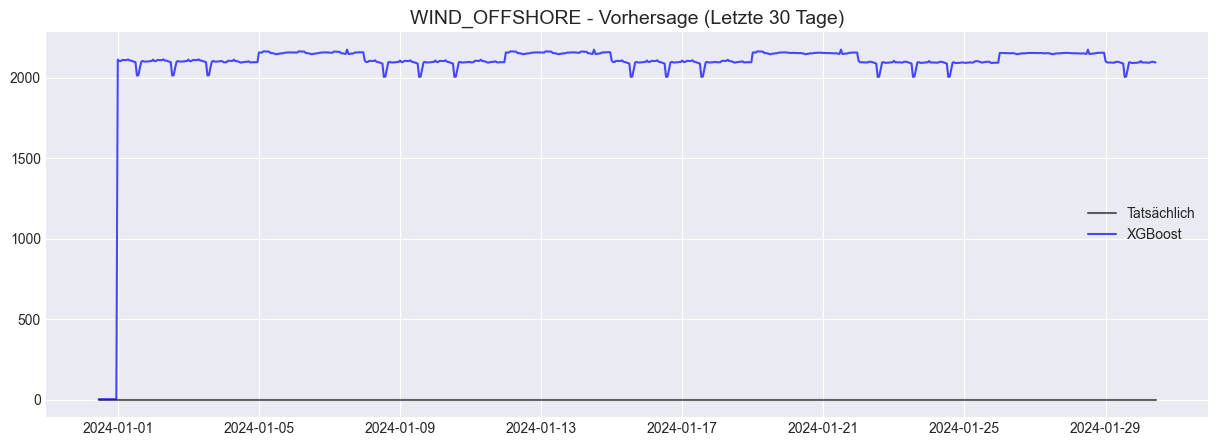


📊 Analysiere: CONSUMPTION
Period: 2022-01-01 to 2024-12-31
  Requesting: https://www.smard.de/app/chart_data/410/DE/410_DE_hour_1641164400000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/410/DE/410_DE_hour_1641769200000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/410/DE/410_DE_hour_1642374000000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/410/DE/410_DE_hour_1642978800000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/410/DE/410_DE_hour_1643583600000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/410/DE/410_DE_hour_1644188400000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/410/DE/410_DE_hour_1644793200000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/410/DE/410_DE_hour_1645398000000.json
    Downloaded 168 records
  Requesting: https:

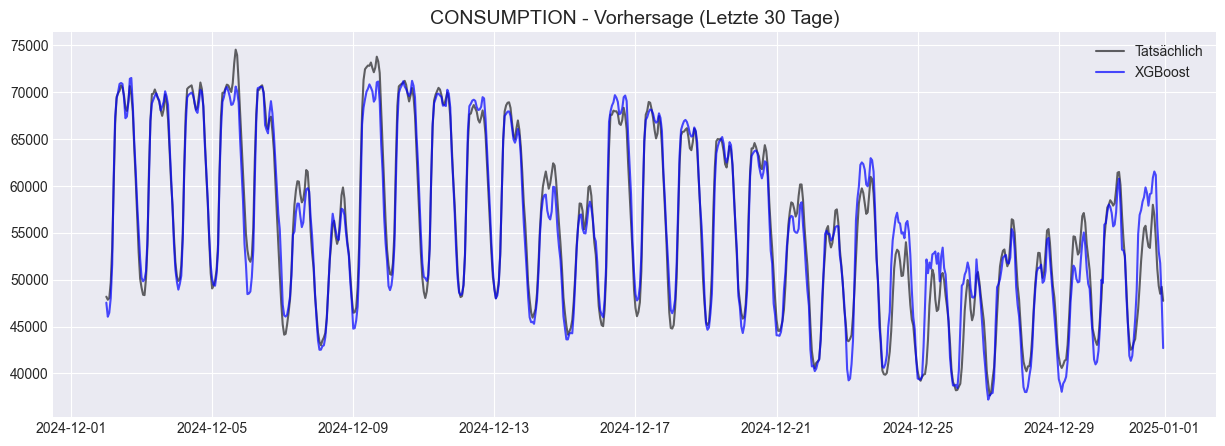


📊 Analysiere: PRICE_DAY_AHEAD
Period: 2022-01-01 to 2024-12-31
  Requesting: https://www.smard.de/app/chart_data/4169/DE/4169_DE_hour_1641164400000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/4169/DE/4169_DE_hour_1641769200000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/4169/DE/4169_DE_hour_1642374000000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/4169/DE/4169_DE_hour_1642978800000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/4169/DE/4169_DE_hour_1643583600000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/4169/DE/4169_DE_hour_1644188400000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/4169/DE/4169_DE_hour_1644793200000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/4169/DE/4169_DE_hour_1645398000000.json
    Downloaded 168 records


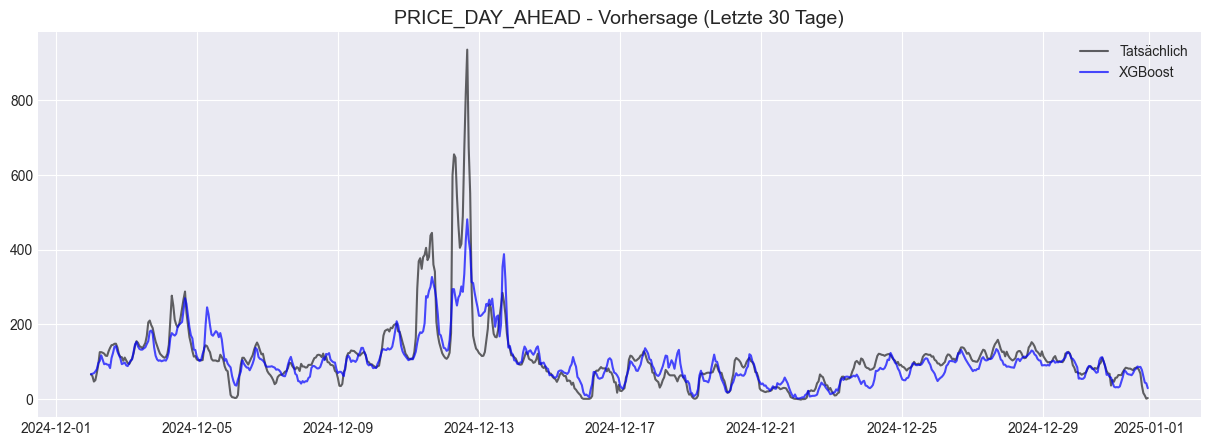

In [4]:
all_results = []
predictions = {}

print(f"🚀 Starte Analyse für {len(DATA_SOURCES)} Zeitreihen...\n")

for source in DATA_SOURCES:
    print(f"\n{'='*50}")
    print(f"📊 Analysiere: {source.upper()}")
    print(f"{'='*50}")
    
    # 1. Daten laden
    try:
        df = load_smard_data(
            filter_name=source,
            start_date=START_DATE,
            end_date=END_DATE,
            resolution='hour',
            cache_dir=Path('../data/raw')
        )
    except Exception as e:
        print(f"⚠️ Fehler beim Laden von {source}: {e}")
        continue
        
    # 2. Feature Engineering
    df_features = create_features(df)
    
    # Features & Target definieren
    features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
                'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
                'lag_24', 'lag_48', 'lag_168', 
                'rolling_mean_24', 'rolling_std_24']
    target = 'value'
    
    X = df_features[features]
    y = df_features[target]
    
    # 3. Train/Test Split
    split_idx = len(df_features) - (TEST_DAYS * 24)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    test_dates = df_features['timestamp'].iloc[split_idx:]
    
    print(f"Trainings-Daten: {len(X_train)} Stunden")
    print(f"Test-Daten: {len(X_test)} Stunden ({TEST_DAYS} Tage)")
    
    # 4. Modelle trainieren
    
    # --- XGBoost ---
    print("  Training XGBoost...")
    xgb = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        early_stopping_rounds=50,
        n_jobs=-1,
        random_state=42
    )
    
    xgb.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    y_pred_xgb = xgb.predict(X_test)
    res_xgb = evaluate_model(y_test, y_pred_xgb, 'XGBoost', source)
    all_results.append(res_xgb)
    print(f"  -> XGBoost R²: {res_xgb['R2']:.4f}")
    
    # --- LightGBM ---
    print("  Training LightGBM...")
    lgb = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        n_jobs=-1,
        random_state=42,
        verbose=-1
    )
    
    lgb.fit(X_train, y_train)
    y_pred_lgb = lgb.predict(X_test)
    res_lgb = evaluate_model(y_test, y_pred_lgb, 'LightGBM', source)
    all_results.append(res_lgb)
    print(f"  -> LightGBM R²: {res_lgb['R2']:.4f}")
    
    # Speichere Vorhersagen für Plotting
    predictions[source] = {
        'dates': test_dates,
        'y_true': y_test,
        'y_xgb': y_pred_xgb,
        'y_lgb': y_pred_lgb
    }
    
    # 5. Plot für diese Zeitreihe
    plt.figure(figsize=(15, 5))
    plt.plot(test_dates, y_test, label='Tatsächlich', color='black', alpha=0.6)
    plt.plot(test_dates, y_pred_xgb, label='XGBoost', color='blue', alpha=0.7)
    plt.title(f'{source.upper()} - Vorhersage (Letzte {TEST_DAYS} Tage)', fontsize=14)
    plt.legend()
    plt.show()

## 4. Vergleich der Ergebnisse

In [5]:
# Ergebnisse in DataFrame umwandeln
results_df = pd.DataFrame(all_results)

# Nach R² sortieren
results_df.sort_values('R2', ascending=False, inplace=True)

print("Zusammenfassung der Ergebnisse:")
display(results_df)

# Speichern
results_df.to_csv('../results/metrics/multi_series_comparison.csv', index=False)

Zusammenfassung der Ergebnisse:


,Dataset,Model,MAE,RMSE,R2,MAPE
7,consumption,LightGBM,1441.461859,1887.186495,0.958261,2.699354
6,consumption,XGBoost,1546.255165,2058.968723,0.950316,2.925698
0,solar,XGBoost,890.601522,1194.558432,0.836359,12.489433
1,solar,LightGBM,889.471468,1207.054248,0.832917,12.271484
8,price_day_ahead,XGBoost,28.233298,52.936203,0.679863,245.762214
9,price_day_ahead,LightGBM,32.626656,58.386747,0.610543,356.703434
2,wind_onshore,XGBoost,1036.572040,1273.107654,0.536631,97.261534
3,wind_onshore,LightGBM,1160.035849,1412.414827,0.429677,127.514140
4,wind_offshore,XGBoost,2078.272816,2097.539170,0.000000,NaN
5,wind_offshore,LightGBM,2041.538466,2059.322119,0.000000,NaN


### Visualisierung des Vergleichs

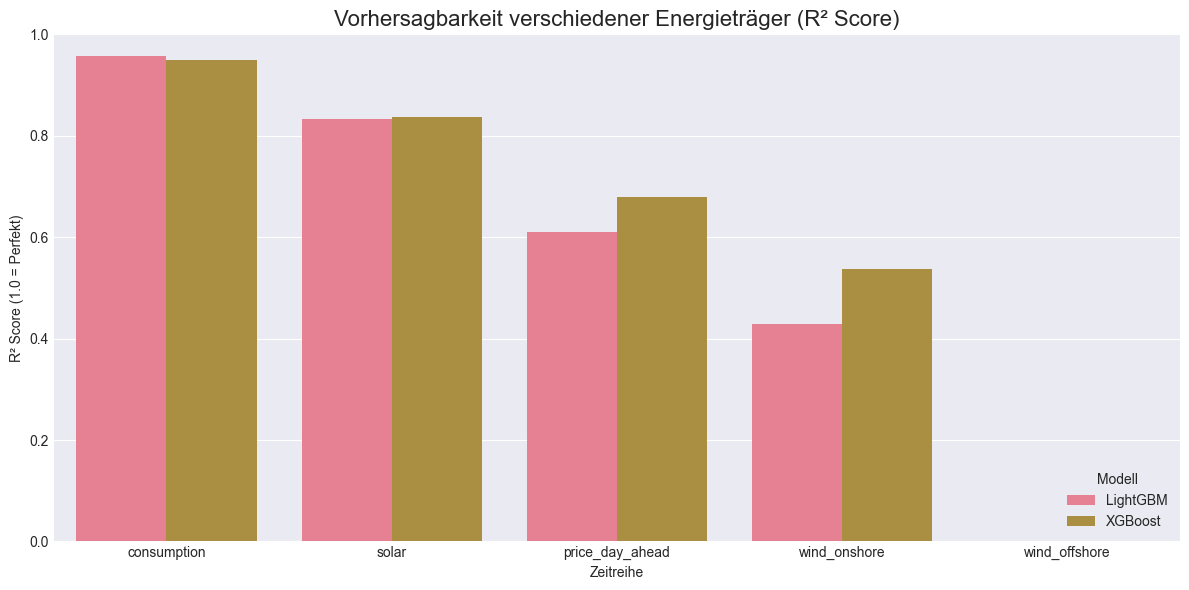

In [6]:
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Dataset', y='R2', hue='Model')
plt.title('Vorhersagbarkeit verschiedener Energieträger (R² Score)', fontsize=16)
plt.ylim(0, 1.0)
plt.ylabel('R² Score (1.0 = Perfekt)')
plt.xlabel('Zeitreihe')
plt.legend(title='Modell', loc='lower right')
plt.tight_layout()
plt.savefig('../results/figures/multi_series_r2_comparison.png')
plt.show()

## 5. Fazit & Interpretation

**Welche Zeitreihe ist am einfachsten vorherzusagen?**
- Normalerweise **Solar**, da der Tag/Nacht-Zyklus sehr stabil ist.
- **Verbrauch** ist oft auch sehr gut vorhersagbar (klare Wochenmuster).

**Welche ist am schwierigsten?**
- **Wind** ist oft chaotischer und wetterabhängiger.
- **Preise** sind am schwierigsten, da sie von allen anderen Faktoren abhängen.

**Empfehlung für die Projektarbeit:**
- Konzentriere dich auf die Zeitreihe, die dich am meisten interessiert, aber erwähne im Fazit die Unterschiede in der Vorhersagbarkeit.